In [2]:
import pandas as pd 
import numpy as np 
import torch 
import ast
import matplotlib.pyplot as plt

In [3]:
train_dict = torch.load("train_pv_xrd.pt")
val_dict = torch.load("val_pv_xrd.pt")
#test_dict = torch.load("test_pv_xrd.pt")

In [4]:
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
#test_df = pd.read_csv("test.csv")

In [5]:
def df_to_spacegroup_data(df): 
    spacegroup_number = np.array(df['spacegroup.number'])
    spacegroup_number_one_hot_encoded = np.eye(230)[spacegroup_number]
    
    return torch.tensor(spacegroup_number_one_hot_encoded)

In [6]:
data_dict = {
    'train': (train_dict, train_df),
    'val': (val_dict, val_df), 
#    'test': (test_dict, test_df)
}

In [7]:
def df_to_spacegroup_data(df): 
    spacegroup_number = np.array(df['spacegroup.number'])
    spacegroup_number_one_hot_encoded = np.eye(230)[spacegroup_number]
    
    return torch.tensor(spacegroup_number_one_hot_encoded)

In [8]:
training_sgs = torch.tensor(train_df['spacegroup.number'], dtype=torch.long)
val_sgs = torch.tensor(val_df['spacegroup.number'], dtype=torch.long)
#test_sgs = df_to_spacegroup_data(test_df)

In [9]:
def convert_to_tensor(pseudo_voight_dict, df): 
    list_of_pseudo_voights = []
    for key in df['material_id']:
        key += "_0"
        value = pseudo_voight_dict[key]
        list_of_pseudo_voights.append(value)

    tensor_of_pseudo_voights = torch.tensor(torch.stack(list_of_pseudo_voights))
    return(tensor_of_pseudo_voights)

In [10]:
training_pvs = convert_to_tensor(train_dict, train_df)
val_pvs = convert_to_tensor(val_dict, val_df)
#test_pvs = convert_to_tensor(test_dict)

/tmp/ipykernel_2427107/1663049170.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_of_pseudo_voights = torch.tensor(torch.stack(list_of_pseudo_voights))


In [11]:
train_df['atomic_numbers'] = train_df['atomic_numbers'].apply(ast.literal_eval)
val_df['atomic_numbers'] = val_df['atomic_numbers'].apply(ast.literal_eval)

In [12]:
from collections import Counter

lst = [4, 4, 5, 6]
count_dict = Counter(lst)

In [13]:
def create_multi_hot_embedding(input_list, max_value = 99):
    # Initialize an array of zeros with length max_value + 1
    multi_hot_embedding = np.zeros(max_value + 1, dtype=int)
    
    #subtract out 1 to index from 0 (hydrogen)
    input_list = [value - 1 for value in input_list]

    # Set the corresponding index for each number in the input list to 1
    for num in input_list:
        multi_hot_embedding[num] += 1
    
    return multi_hot_embedding

In [14]:
def create_2D_embedding(input_list, max_value = 99):
    # Initialize an array of zeros with length max_value + 1
    multi_hot_embedding = np.zeros((21, max_value + 1), dtype=int)
    
    #subtract out 1 to index from 0 (hydrogen)
    input_list = [value - 1 for value in input_list]
    count_dict = Counter(input_list)

    # Set the corresponding index for each number in the input list to 1
    for key, value in count_dict.items():
        multi_hot_embedding[value, key] = 1
    
    return multi_hot_embedding

In [15]:
train_df['composition_multihot'] = train_df['atomic_numbers'].apply(create_multi_hot_embedding)
val_df['composition_multihot'] = val_df['atomic_numbers'].apply(create_multi_hot_embedding)

train_df['composition_2D'] = train_df['atomic_numbers'].apply(create_2D_embedding)
val_df['composition_2D'] = val_df['atomic_numbers'].apply(create_2D_embedding)


In [16]:
train_composition = torch.tensor(train_df['composition_multihot'])
val_composition = torch.tensor(val_df['composition_multihot'])

train_composition = train_composition.unsqueeze(1)
val_composition = val_composition.unsqueeze(1)

In [17]:
train_composition2D = torch.tensor(train_df['composition_2D'])
val_composition2D = torch.tensor(val_df['composition_2D'])

train_composition2D = train_composition2D.unsqueeze(1)
val_composition2D = val_composition2D.unsqueeze(1)

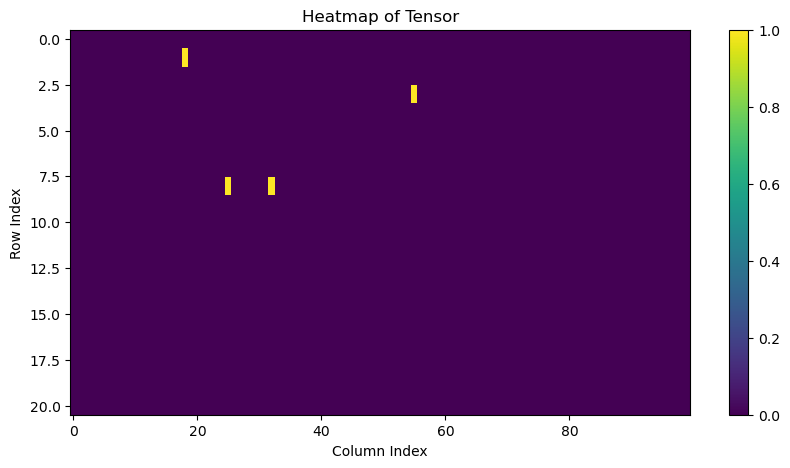

In [18]:
# Create a random tensor with the shape [21, 100]
tensor = train_composition2D[4][0]

# Use matplotlib to create a heatmap
plt.figure(figsize=(10, 5))
plt.imshow(tensor, aspect='auto')
plt.colorbar()
plt.title('Heatmap of Tensor')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

In [19]:
torch.save(training_pvs, "train_pvs.pt")
torch.save(val_pvs, "val_pvs.pt")
torch.save(training_sgs, "train_sgs.pt")
torch.save(val_sgs, "val_sgs.pt")
torch.save(train_composition, "train_composition.pt")
torch.save(val_composition, "val_composition.pt")

torch.save(train_composition2D, "train_composition2D.pt")
torch.save(val_composition2D, "val_composition2D.pt")